# Helmet Detection YOLOV8


## Table of Contents
1. [Setup and Imports](#setup)
2. [Dataset Exploration and Stats](#dataset)
3. [Model Training](#training)
4. [Training Visualization](#visualization)
5. [Model Export](#export)

## 1. Setup and Imports <a id='setup'></a>

In [1]:

%pip install ultralytics opencv-python matplotlib seaborn
%pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu124



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/nightly/cu124
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torchaudio (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for torchaudio


In [2]:
import os
from pathlib import Path
import yaml
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
from datetime import datetime
from PIL import Image
import pandas as pd

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.10.0+cpu
CUDA available: False


## 2. Dataset Exploration <a id='dataset'></a>

In [3]:
# Load dataset configuration
data_yaml_path = 'data/raw/data.yaml'

with open(data_yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print("Dataset Configuration:")
print(f"Number of classes: {data_config['nc']}")
print(f"Class names: {data_config['names']}")
print(f"\nPaths:")
print(f"Training: {data_config['train']}")
print(f"Validation: {data_config['val']}")

Dataset Configuration:
Number of classes: 1
Class names: ['Helmet']

Paths:
Training: ../train/images
Validation: ../valid/images



Dataset Statistics:
Training images: 599
Training labels: 599
Validation images: 170
Validation labels: 170


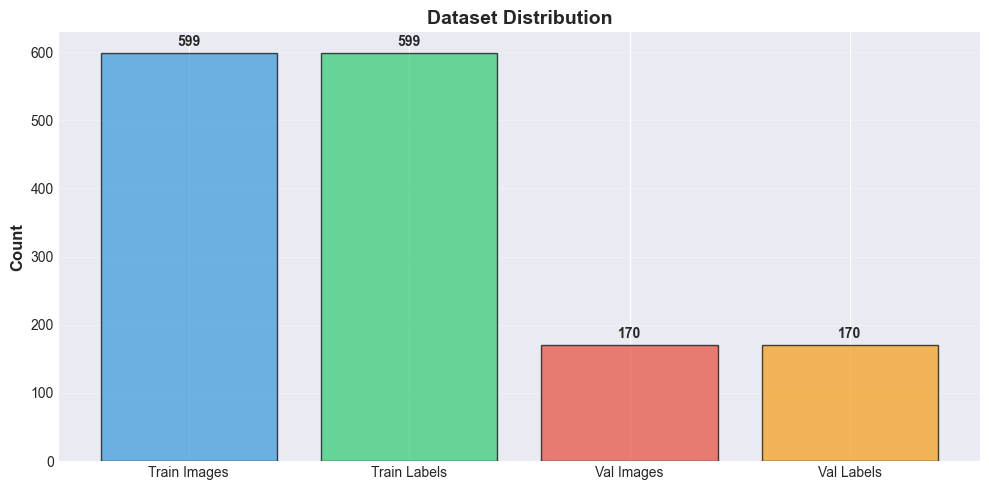

In [4]:
# Count dataset statistics
data_root = Path('data/raw')

train_images = list((data_root / 'train' / 'images').glob('*.*'))
train_labels = list((data_root / 'train' / 'labels').glob('*.txt'))
val_images = list((data_root / 'valid' / 'images').glob('*.*'))
val_labels = list((data_root / 'valid' / 'labels').glob('*.txt'))

print("\nDataset Statistics:")
print(f"Training images: {len(train_images)}")
print(f"Training labels: {len(train_labels)}")
print(f"Validation images: {len(val_images)}")
print(f"Validation labels: {len(val_labels)}")

# Create visualization
fig, ax = plt.subplots(figsize=(10, 5))
categories = ['Train Images', 'Train Labels', 'Val Images', 'Val Labels']
counts = [len(train_images), len(train_labels), len(val_images), len(val_labels)]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

ax.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Dataset Distribution', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

for i, (cat, count) in enumerate(zip(categories, counts)):
    ax.text(i, count + 10, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Training Samples:


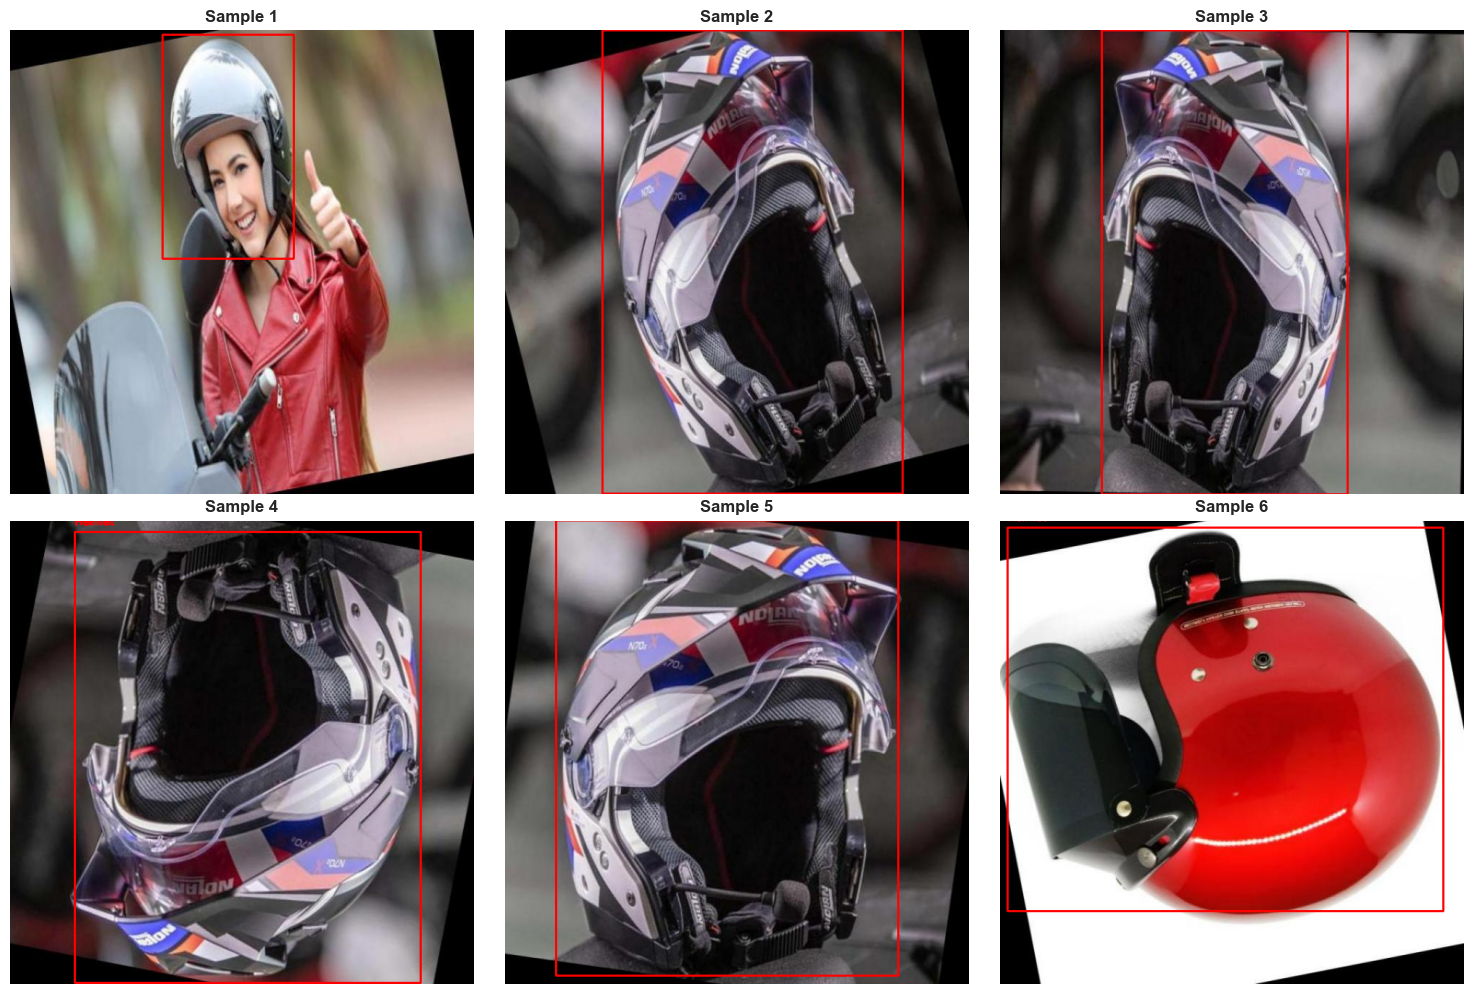

In [5]:
# Visualize sample images
def visualize_samples(image_paths, label_paths, num_samples=6):
    """
    Visualize sample images with bounding boxes
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx in range(min(num_samples, len(image_paths))):
        # Load image
        img_path = image_paths[idx]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Load corresponding label
        label_path = label_paths[idx]
        
        if label_path.exists():
            with open(label_path, 'r') as f:
                labels = f.readlines()
            
            # Draw bounding boxes
            for label in labels:
                parts = label.strip().split()
                if len(parts) == 5:
                    class_id, x_center, y_center, width, height = map(float, parts)
                    
                    # Convert to pixel coordinates
                    x_center *= w
                    y_center *= h
                    width *= w
                    height *= h
                    
                    x1 = int(x_center - width / 2)
                    y1 = int(y_center - height / 2)
                    x2 = int(x_center + width / 2)
                    y2 = int(y_center + height / 2)
                    
                    # Draw rectangle
                    color = (255, 0, 0) if int(class_id) == 0 else (0, 255, 0)
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    
                    # Add label
                    class_name = data_config['names'][int(class_id)]
                    cv2.putText(img, class_name, (x1, y1-10), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Display
        axes[idx].imshow(img)
        axes[idx].set_title(f"Sample {idx+1}", fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Training Samples:")
visualize_samples(train_images[:6], 
                 [Path(str(p).replace('images', 'labels').replace(p.suffix, '.txt')) 
                  for p in train_images[:6]])

## 3. Model Training <a id='training'></a>

In [ ]:
# Training configuration
CONFIG = {
    'model_size': 'n',      
    'epochs': 100,
    'batch_size': 16,
    'img_size': 640,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'patience': 50,         
    'lr0': 0.01,           
    'lrf': 0.01,           
}

print("Training Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Training Configuration:
  model_size: n
  epochs: 100
  batch_size: 16
  img_size: 640
  device: cpu
  patience: 50
  lr0: 0.01
  lrf: 0.01


In [7]:
# Initialize model
model_name = f"yolov8{CONFIG['model_size']}.pt"
model = YOLO(model_name)

print(f"\nModel initialized: {model_name}")
print(f"Using device: {CONFIG['device']}")


Model initialized: yolov8n.pt
Using device: cpu


In [ ]:
# Train the model
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
project_name = 'runs/detect'
run_name = f'helmet_detection_{timestamp}'

print(f"Starting training...")
print(f"Results will be saved to: {project_name}/{run_name}")
print("\nThis may take a while depending on your hardware...\n")

results = model.train(
    data=data_yaml_path,
    epochs=CONFIG['epochs'],
    imgsz=CONFIG['img_size'],
    batch=CONFIG['batch_size'],
    device=CONFIG['device'],
    project=project_name,
    name=run_name,
    patience=CONFIG['patience'],
    save=True,
    save_period=10,
    plots=True,
    lr0=CONFIG['lr0'],
    lrf=CONFIG['lrf'],
    verbose=True,
    amp=True, 
)

print("\n✓ Training completed!")

Starting training...
Results will be saved to: runs/detect/helmet_detection_20260216_163341

This may take a while depending on your hardware...

Ultralytics 8.4.14  Python-3.12.10 torch-2.10.0+cpu CPU (AMD Ryzen 9 270 w/ Radeon 780M Graphics)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/raw/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937

## 4. Training Visualization <a id='visualization'></a>

In [ ]:
# Load training results
results_dir = Path(project_name) / run_name
results_csv = results_dir / 'results.csv'

if results_csv.exists():
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip() 
    
    print("Training Metrics:")
    print(df.head())
else:
    print("Results CSV not found")

Training Metrics:
   epoch     time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1  127.000         1.37862         2.10361         1.52080   
1      2  233.671         1.47992         1.70849         1.56275   
2      3  359.166         1.47890         1.66934         1.60177   
3      4  490.665         1.53333         1.64445         1.64268   
4      5  620.666         1.59298         1.57570         1.64554   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.79126            0.23420           0.45044   
1               0.38732            0.47584           0.32131   
2               0.47110            0.44039           0.39774   
3               0.54951            0.47584           0.46053   
4               0.56691            0.51095           0.52543   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.22021       1.43916       3.05480       1.85649  0.000649   
1              0.13514    

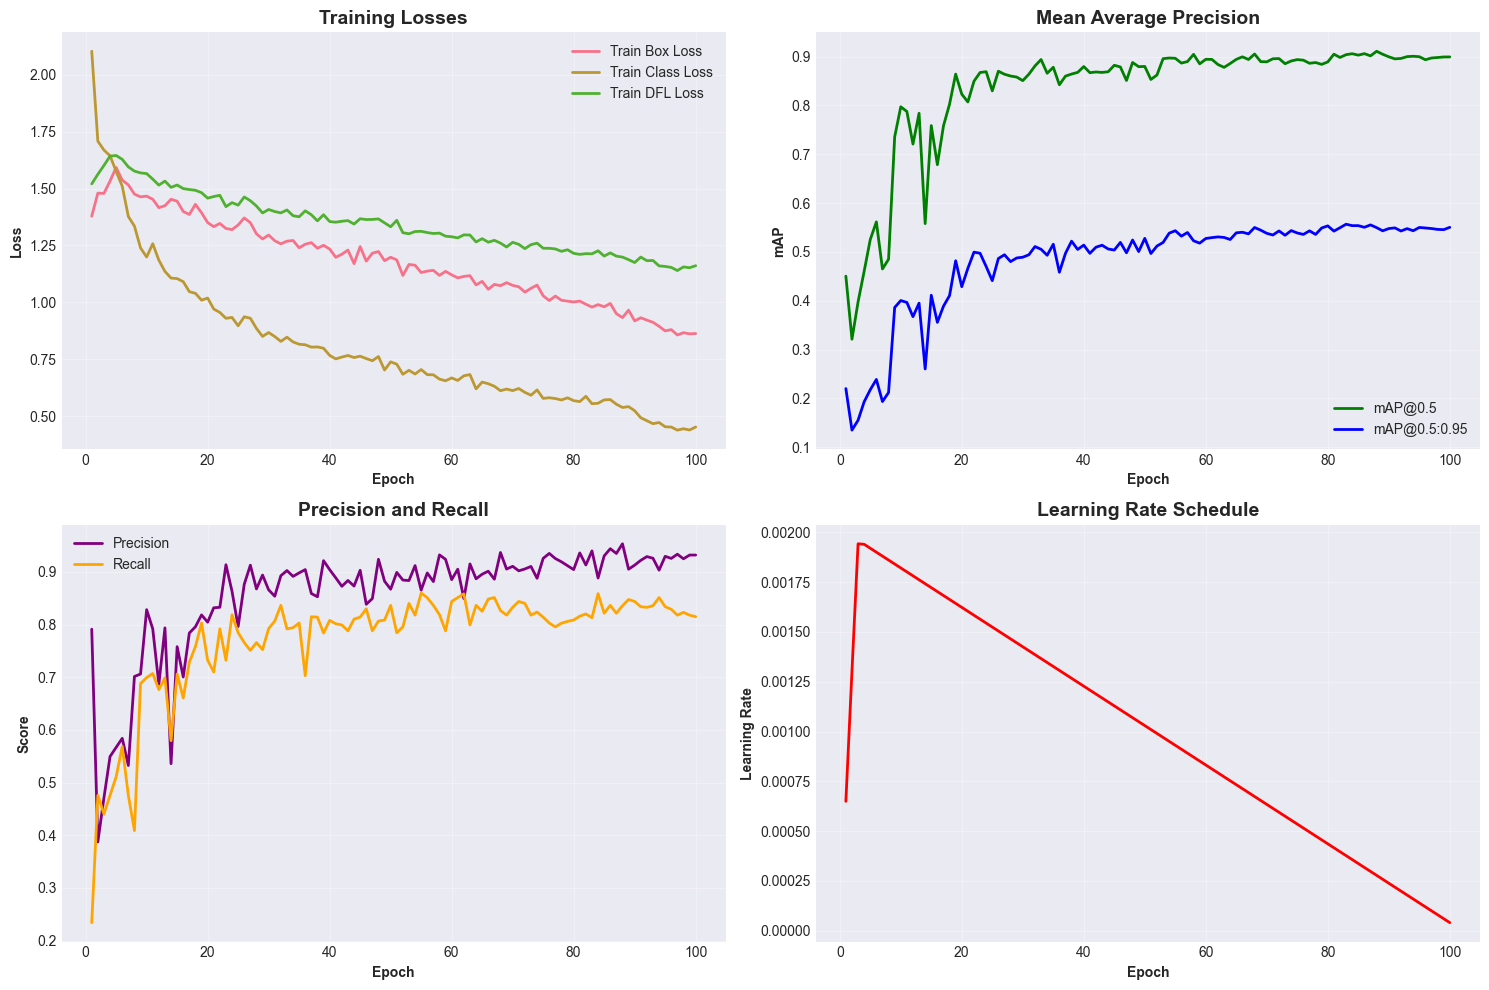


Final Metrics:
  mAP@0.5: 0.8994
  mAP@0.5:0.95: 0.5504
  Precision: 0.9320
  Recall: 0.8149


In [17]:
# Plot training curves
if results_csv.exists():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss curves
    axes[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linewidth=2)
    axes[0, 0].plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', linewidth=2)
    axes[0, 0].plot(df['epoch'], df['train/dfl_loss'], label='Train DFL Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch', fontweight='bold')
    axes[0, 0].set_ylabel('Loss', fontweight='bold')
    axes[0, 0].set_title('Training Losses', fontweight='bold', fontsize=14)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # mAP curves
    axes[0, 1].plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5', linewidth=2, color='green')
    axes[0, 1].plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95', linewidth=2, color='blue')
    axes[0, 1].set_xlabel('Epoch', fontweight='bold')
    axes[0, 1].set_ylabel('mAP', fontweight='bold')
    axes[0, 1].set_title('Mean Average Precision', fontweight='bold', fontsize=14)
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Precision and Recall
    axes[1, 0].plot(df['epoch'], df['metrics/precision(B)'], label='Precision', linewidth=2, color='purple')
    axes[1, 0].plot(df['epoch'], df['metrics/recall(B)'], label='Recall', linewidth=2, color='orange')
    axes[1, 0].set_xlabel('Epoch', fontweight='bold')
    axes[1, 0].set_ylabel('Score', fontweight='bold')
    axes[1, 0].set_title('Precision and Recall', fontweight='bold', fontsize=14)
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Learning rate
    if 'lr/pg0' in df.columns:
        axes[1, 1].plot(df['epoch'], df['lr/pg0'], linewidth=2, color='red')
        axes[1, 1].set_xlabel('Epoch', fontweight='bold')
        axes[1, 1].set_ylabel('Learning Rate', fontweight='bold')
        axes[1, 1].set_title('Learning Rate Schedule', fontweight='bold', fontsize=14)
        axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print("\nFinal Metrics:")
    print(f"  mAP@0.5: {df['metrics/mAP50(B)'].iloc[-1]:.4f}")
    print(f"  mAP@0.5:0.95: {df['metrics/mAP50-95(B)'].iloc[-1]:.4f}")
    print(f"  Precision: {df['metrics/precision(B)'].iloc[-1]:.4f}")
    print(f"  Recall: {df['metrics/recall(B)'].iloc[-1]:.4f}")

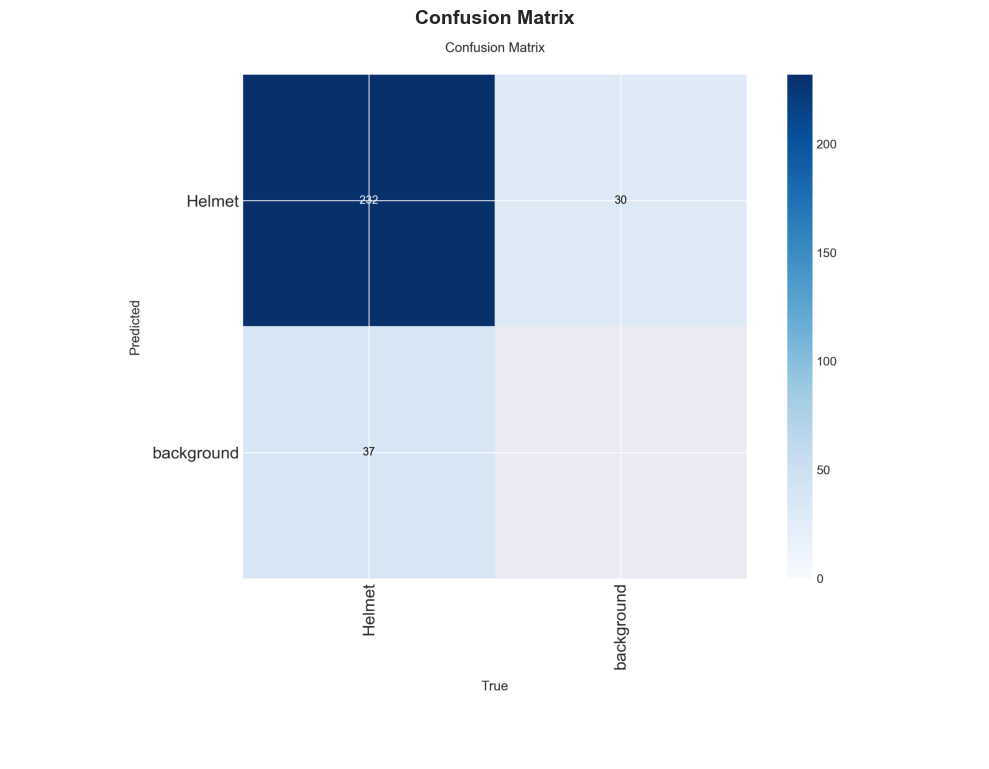

In [18]:
# Display confusion matrix
cm_path = results_dir / 'confusion_matrix.png'

if cm_path.exists():
    img = Image.open(cm_path)
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Confusion Matrix', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix not found")

## 5. Model Export <a id='export'></a>

In [19]:
# Save best model to models directory
best_model_path = results_dir / 'weights' / 'best.pt'
models_dir = Path('models')
models_dir.mkdir(exist_ok=True)

final_model_path = models_dir / f'helmet_detector_best_{timestamp}.pt'

if best_model_path.exists():
    import shutil
    shutil.copy(best_model_path, final_model_path)
    print(f"✓ Best model saved to: {final_model_path}")
    print(f"  Model size: {final_model_path.stat().st_size / (1024*1024):.2f} MB")
else:
    print("Best model not found")

✓ Best model saved to: models\helmet_detector_best_20260216_163341.pt
  Model size: 5.97 MB



image 1/1 e:\Helmet Detection YoloV8\data\raw\valid\images\076311700_1639448964-0000467208_jpg.rf.f22086afcb9b499e34c0a81718a1f809.jpg: 640x640 1 Helmet, 37.5ms
Speed: 1.8ms preprocess, 37.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


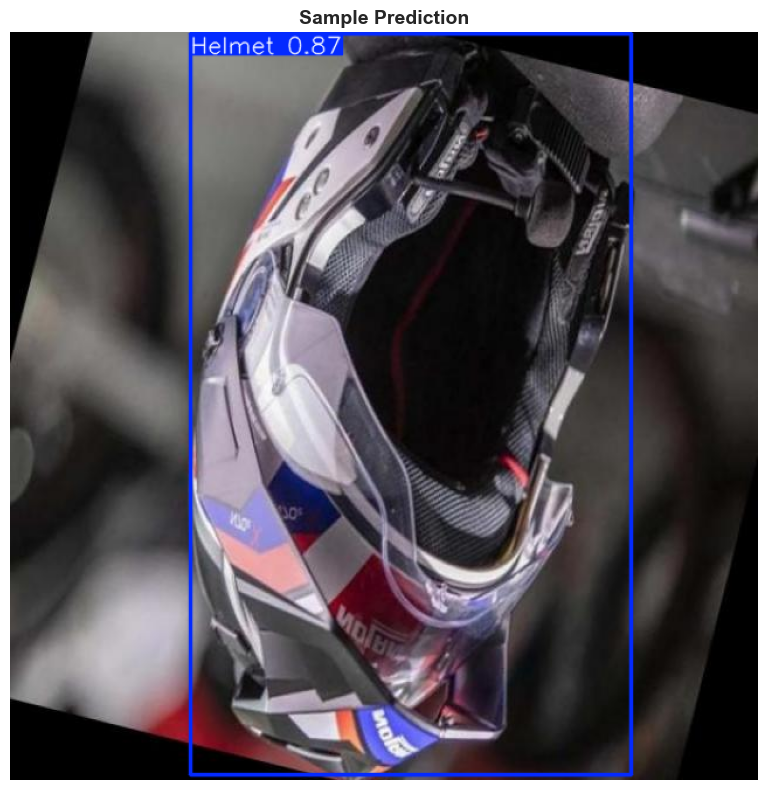


Detections:
  [1] Helmet: 0.87


In [21]:
# Test inference on a sample image
if len(val_images) > 0:
    # Load best model
    best_model = YOLO(final_model_path)
    
    # Run inference on first validation image
    test_img_path = val_images[0]
    results = best_model.predict(source=test_img_path, conf=0.25)
    
    # Display result
    annotated = results[0].plot()
    
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Sample Prediction', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print detections
    print("\nDetections:")
    for i, box in enumerate(results[0].boxes):
        cls = int(box.cls[0])
        conf = float(box.conf[0])
        class_name = data_config['names'][cls]
        print(f"  [{i+1}] {class_name}: {conf:.2f}")
else:
    print("No validation images available for testing")

## Summary

### Refer to the Below Mentioned Files For Further Evaluation

1. Review the training metrics and visualizations above
2. Run comprehensive evaluation: `Evaluate.py`
3. Test inference: `python Inference.py --type image --source <image_path>`
4. Deploy API: `python Api.py`

**Model Location:**
- Best model saved to `models/` directory
- Training results in `runs/detect/` directory
